In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
random.seed(0)
torch.cuda.manual_seed_all(999)

In [2]:
# 데이터 전처리

df = pd.read_csv('SJ001_merge_1day_full.csv')

# Outlier mean값으로 대체
data = df.iloc[:, 1:].values
for i in range(len(data)):
    if data[i, 2] > 500:
        data[i, 2] = (data[i-1, 2] + data[i+1, 2])/2 

solar_max = data.max(axis=0)[2]
capacity_value = 500

# 월별 평균치 계산 (한달을 31일로 가정)
g_avg = np.zeros((12, 97))

for i in range(12):
    group = df[(df.DATE >= 0+30*i) & (df.DATE <= 30+30*i)].groupby('DATE')
    group = group.filter(lambda x: x['GEN_ENERGY'].mean() >= 100)
    g_avg[i,:] = group.groupby('TIME').mean()['GEN_ENERGY'].values


date = data[:,0]
time = data[:,1]

d=(date/31).astype('int')
t = ((time-5)*6.01).astype('int')

df['avg'] = g_avg[d,t]

#평균치를 데이터에 포함시켜서 0~1사이로 scaling
data = df.iloc[:, 1:].values
for i in range(len(data)):
    if data[i, 2] > 500:
        data[i, 2] = (data[i-1, 2] + data[i+1, 2])/2 

maxi = data.max(axis=0)
mini = data.min(axis=0)
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

In [3]:
# Training 데이터 생성 (데이터는 [에너지, 날짜, 시간, 예보5개, 월별 평균량] 으로 구성)
train_day = 497
test_day = 29

interval = 97
# input_size = 8
input_size = 9

train_num = 97* (train_day-1) + 1
test_num = 97* (test_day-1) + 1

input_series = np.zeros((train_num + test_num, interval, input_size))
target_series = np.zeros((train_num + test_num, interval, input_size))

for i in range(train_num + test_num):
    if i < train_num:
        input_series[i, :, 0] = data[i: i+interval, 2]
        input_series[i, :, 1:3] = data[i: i+interval, 0:2]
    #     input_series[i, :, 3:8] = data[i: i+interval, -6:-1]
        input_series[i, :, 3:9] = data[i: i+interval, -6:]

        target_series[i, :, 0] = data[i+interval: i+interval*2, 2]
        target_series[i, :, 1:3] = data[i+interval: i+interval*2, 0:2]
    #     target_series[i, :, 3:8] = data[i+interval: i+interval*2, -6:-1]
        target_series[i, :, 3:9] = data[i+interval: i+interval*2, -6:]
    else:
        input_series[i, :, 0] = data[i+interval-1: i+interval*2-1, 2]
        input_series[i, :, 1:3] = data[i+interval-1: i+interval*2-1, 0:2]
        input_series[i, :, 3:9] = data[i+interval-1: i+interval*2-1, -6:]

        target_series[i, :, 0] = data[i+interval*2-1: i+interval*3-1, 2]
        target_series[i, :, 1:3] = data[i+interval*2-1: i+interval*3-1, 0:2]
        target_series[i, :, 3:9] = data[i+interval*2-1: i+interval*3-1, -6:]        

input_series = torch.from_numpy(input_series).to(device)
target_series = torch.from_numpy(target_series).to(device)
    
X_train = input_series[:train_num]
X_test = input_series[train_num: train_num + test_num]
y_train = target_series[:train_num]
y_test = target_series[train_num: train_num + test_num]

In [4]:
# Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden):
        batch_size, seq_len = input.shape[0], input.shape[1]
        output = input.float()
        hidden = hidden.float()
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [5]:
# Decoder + Attention
class AttnDecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(AttnDecoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.attn = nn.Linear(self.hidden_size + self.input_size, interval)
        self.attn_combine = nn.Linear(self.hidden_size + self.input_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first = True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output):
        batch_size = input.shape[0]
        input = input.view(batch_size, 1, self.input_size).float()
        hidden = hidden.float()

        hidd_att = hidden.view(batch_size, 1, self.hidden_size)

        attn_weights = F.softmax(self.attn(torch.cat((input, hidd_att), 2)), dim = 2)
        attn_applied = torch.bmm(attn_weights, encoder_output)

        output = torch.cat((input, attn_applied), 2)
        output = self.attn_combine(output)
        output = F.relu(output)

        output, hidden = self.gru(output, hidden)
#         output = nn.Sigmoid()(output)
        output = F.relu(self.out(output))
        
        return output, hidden, attn_weights

In [6]:
hidden_size = 16
encoder1 = EncoderRNN(input_size, hidden_size).to(device)
decoder1 = AttnDecoderRNN(input_size, hidden_size, 1).to(device)

In [7]:
teacher_forcing_ratio = 0.5
max_grad_norm = 1

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size = batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
    decoder_input = input_tensor[:, -1:, :]
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    outputs = []
    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
            outputs.append(decoder_output.squeeze(0))
            decoder_input = target_tensor[:, di:di+1, :] # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input 
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
            outputs.append(decoder_output.squeeze(0))
            decoder_input = torch.cat([decoder_output, target_tensor[:, di:di+1, 1:].float()], dim=2)
            
        
    outputs = torch.stack(outputs, dim=1).view(batch_size, target_length, 1)
    loss = criterion(outputs, target_tensor[:, :, 0:1].float())

    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_grad_norm)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_grad_norm)
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [8]:
def trainIters(encoder, decoder, batch_size = 50, epoch = 100, n_iters=train_num, print_every=1000, plot_every=100, learning_rate=0.001):
    plot_losses = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    for ep in range(epoch):
        loss = 0
        
        for b in range(int(train_num / batch_size)):
            input_tensor = X_train[batch_size*b:batch_size*(b+1)]
            target_tensor = y_train[batch_size*b:batch_size*(b+1)]

            loss += train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        loss = loss/ int(train_num / batch_size)    
        plot_losses.append(loss)
        print("Epoch ", ep+1, "MSE: ", loss*100)
    plt.plot(plot_losses)

Epoch  1 MSE:  0.005717411196977367
Epoch  2 MSE:  0.005559306241236328
Epoch  3 MSE:  0.005830007109361737
Epoch  4 MSE:  0.0057559163473630045
Epoch  5 MSE:  0.0057765968509374335
Epoch  6 MSE:  0.005520525354107842
Epoch  7 MSE:  0.005715165394328231
Epoch  8 MSE:  0.0059812208678527885
Epoch  9 MSE:  0.005840451070991392
Epoch  10 MSE:  0.005742515226125823


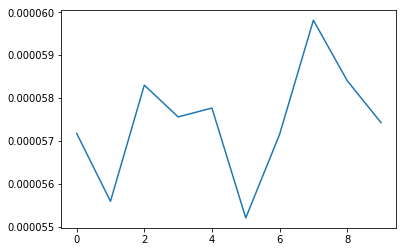

In [49]:
trainIters(encoder1, decoder1, epoch=10)

In [9]:
def evaluate(encoder, decoder, input_tensor, target_tensor, target_length):
    with torch.no_grad():
        input_tensor = input_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)
        input_length = input_tensor.size()[1]
        encoder_hidden = encoder.initHidden(batch_size = 1)

        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = input_tensor[:, -1:, :] 
        decoder_hidden = encoder_hidden
        
        decoded = []
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(decoder_input, decoder_hidden, encoder_output)
#             if di <= 6:
#                 decoder_output = decoder_output * 0
            decoded.append(decoder_output.item())
            decoder_input = torch.cat([decoder_output, target_tensor[:, di:di+1, 1:].float()], dim=2)
            
        return decoded

In [10]:
# torch.save(encoder1, 'encoder1_24h')
# torch.save(decoder1, 'decoder1_24h')
encoder1 = torch.load('encoder1_24h')
decoder1 = torch.load('decoder1_24h')
predicted = torch.zeros(test_day * interval).to(device)
for i in range(test_day):
    dec = evaluate(encoder1, decoder1, X_test[interval*i], y_test[interval*i], interval)
    predicted[interval*i: interval*(i+1)] = torch.Tensor(dec)


loss = nn.MSELoss()
whole_data = torch.from_numpy(data[-interval*test_day:,2]).to(device).float()
# train_loss = loss(predicted[:interval*train_day], whole_data[:interval*train_day])
test_loss = loss(predicted, whole_data)
NRMSE = torch.sqrt(test_loss) / whole_data.max()
NMAE = torch.abs(predicted-whole_data)
NMAE = torch.sum(NMAE) * 100 * solar_max / len(predicted) / capacity_value
print("hidden_node : %d" %(hidden_size))
# print("train_loss : %f" %(train_loss))
print("test_loss : %f" %(test_loss))
print("NRMSE : %f" %(NRMSE))
print("NMAE : %f" %(NMAE))

hidden_node : 16
test_loss : 0.012060
NRMSE : 0.114846
NMAE : 6.679121


In [1]:
df2 = pd.read_csv('SJ002_merge_1day_full.csv')
data2 = df2.iloc[:, 1:].values
for i in range(len(data2)):
    if data2[i, 2] > 500:
        data2[i, 2] = (data2[i-1, 2] + data2[i+1, 2])/2 

g_avg = np.zeros((12, 97))

for i in range(12):
    group = df2[(df2.DATE >= 0+30*i) & (df2.DATE <= 30+30*i)].groupby('DATE')
    group = group.filter(lambda x: x['GEN_ENERGY'].mean() >= 100)
    g_avg[i,:] = group.groupby('TIME').mean()['GEN_ENERGY'].values

date = data2[:,0]
time = data2[:,1]

d=(date/31).astype('int')
t = ((time-5)*6.01).astype('int')

df2['avg'] = g_avg[d,t]
ind = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
data2 = df2.iloc[:, ind].values
for i in range(len(data2)):
    if data2[i, 2] > 500:
        data2[i, 2] = (data2[i-1, 2] + data2[i+1, 2])/2 
data2 = (data2 - mini) / (maxi - mini)

NameError: name 'pd' is not defined

In [12]:
# 각 월별 1일이 1월1일부터 몇번째 날인가 계산
month = np.zeros(13)
from datetime import date
for i in range(12):
    month[i] = (date(2018, i+1, 1) - date(2017, 12, 31)).days
month[12] = 366
month = month.astype('int')
month

array([  1,  32,  60,  91, 121, 152, 182, 213, 244, 274, 305, 335, 366])

In [13]:
# month_index => 첫번째 값 = 29 means 타겟데이터의 29일치가 1월달 데이터
k = df2.values[:,1]
month_index = np.zeros(13)
m = 1
for i in range(len(df2)-interval):
    if (int(k[i+interval-1]) < month[m]) and (int(k[i+interval]) >= month[m]):
        month_index[m] = i/97
        m += 1
    else:
        pass
month_index[0] = 0
month_index[-1]=336
month_index = month_index.astype('int')
month_index

array([  0,  29,  45,  66,  96, 126, 156, 184, 215, 245, 275, 305, 336])

In [14]:
test_day = 336
test_num = 97* test_day
s2_input_series = np.zeros((test_num, interval, input_size))
s2_target_series = np.zeros((test_num, interval, input_size))

for i in range(test_num):
    s2_input_series[i, :, 0] = data2[i: i+interval, 2]
    s2_input_series[i, :, 1:3] = data2[i: i+interval, 0:2]
    s2_input_series[i, :, 3:9] = data2[i: i+interval, -6:]
    
    s2_target_series[i, :, 0] = data2[i+interval: i+interval*2, 2]
    s2_target_series[i, :, 1:3] = data2[i+interval: i+interval*2, 0:2]
    s2_target_series[i, :, 3:9] = data2[i+interval: i+interval*2, -6:]
    
s2_input_series = torch.from_numpy(s2_input_series).to(device)
s2_target_series = torch.from_numpy(s2_target_series).to(device)

In [15]:
# epoch = 50
predicted = torch.zeros(interval * test_day).to(device)
for i in range(test_day):
    dec = evaluate(encoder1, decoder1, s2_input_series[interval*i], s2_target_series[interval*i], interval)
    predicted[interval*i: interval*(i+1)] = torch.Tensor(dec)

loss = nn.MSELoss()
whole_data = torch.from_numpy(data2[interval:interval + interval* test_day,2]).to(device).float()
test_loss = loss(predicted, whole_data)
NRMSE = torch.sqrt(test_loss) / whole_data.max()
NMAE = torch.sum(torch.abs(predicted-whole_data)) * 100 * solar_max / len(predicted) / capacity_value
print("NRMSE : %f" %(NRMSE))
print("NMAE : %f" %(NMAE))

NRMSE : 0.108283
NMAE : 6.233893


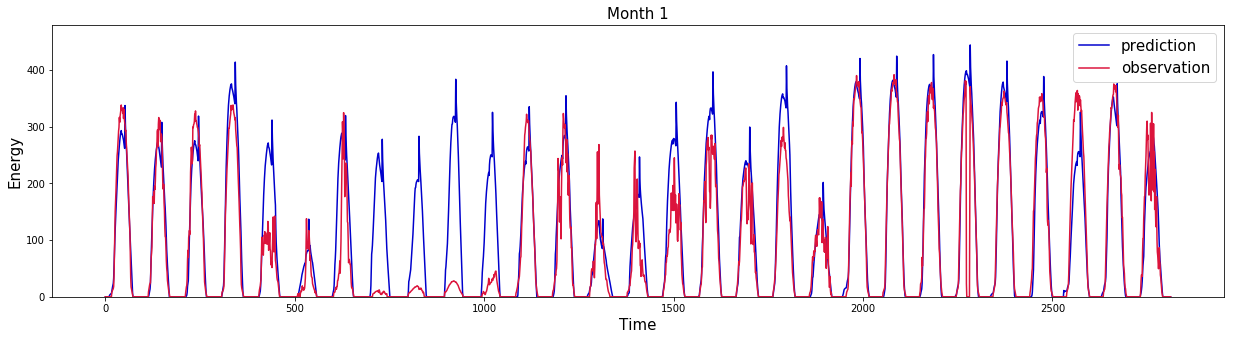

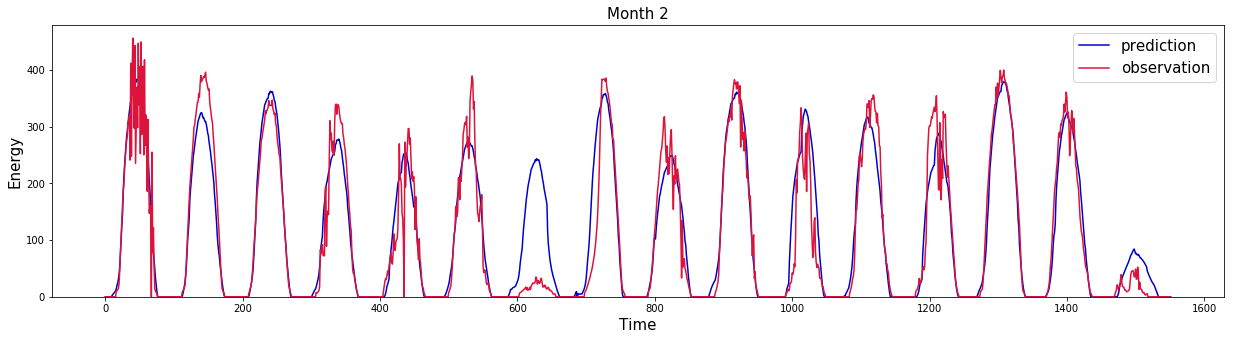

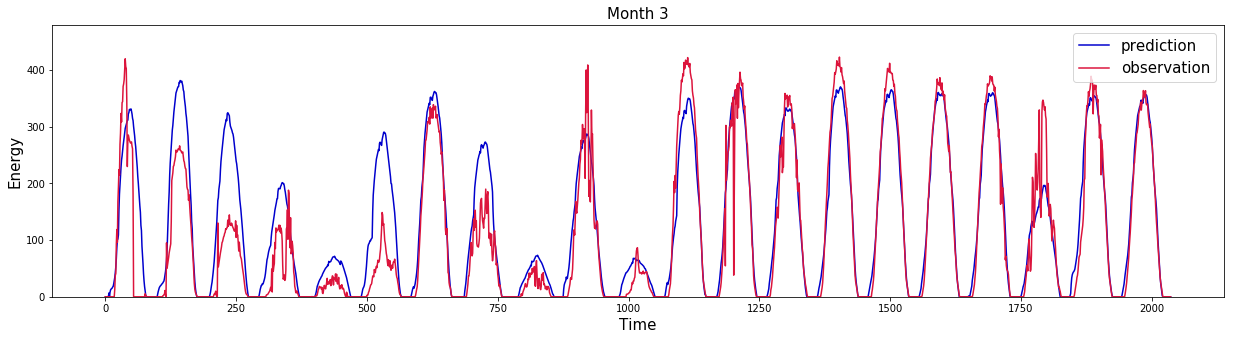

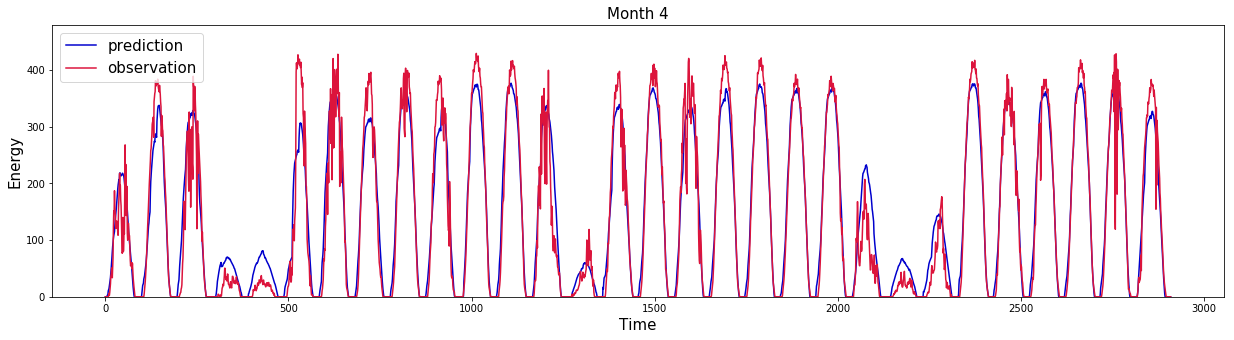

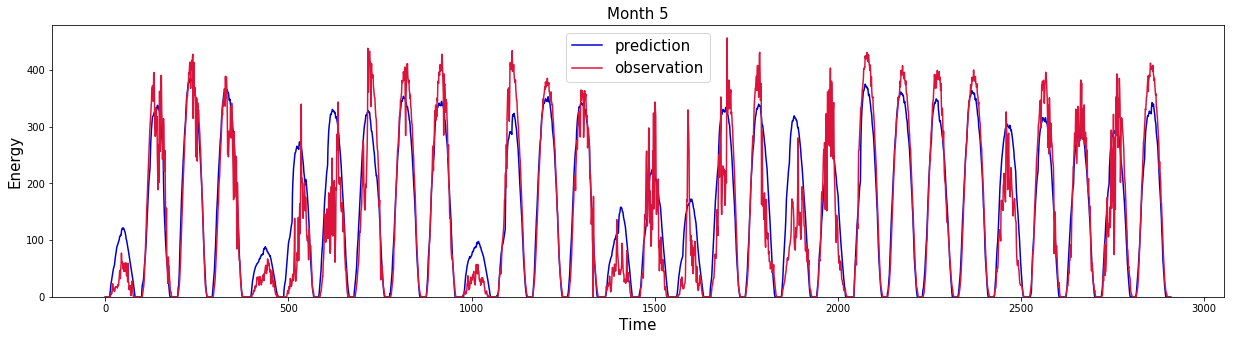

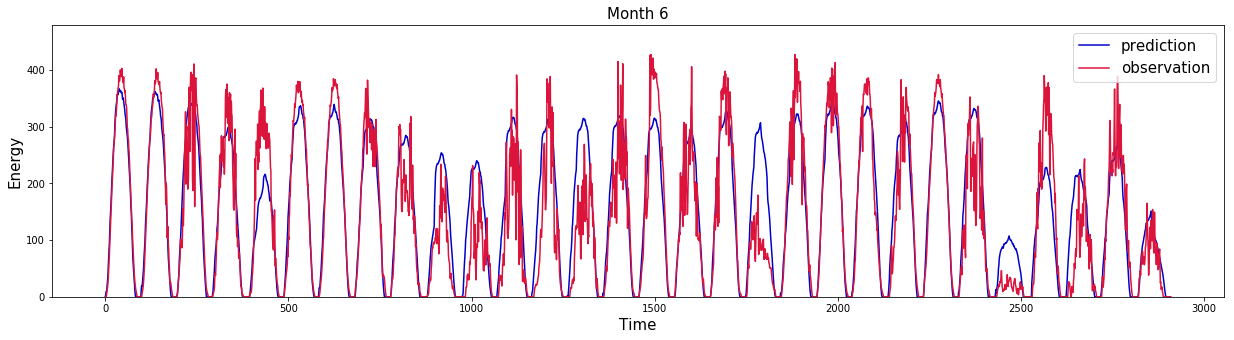

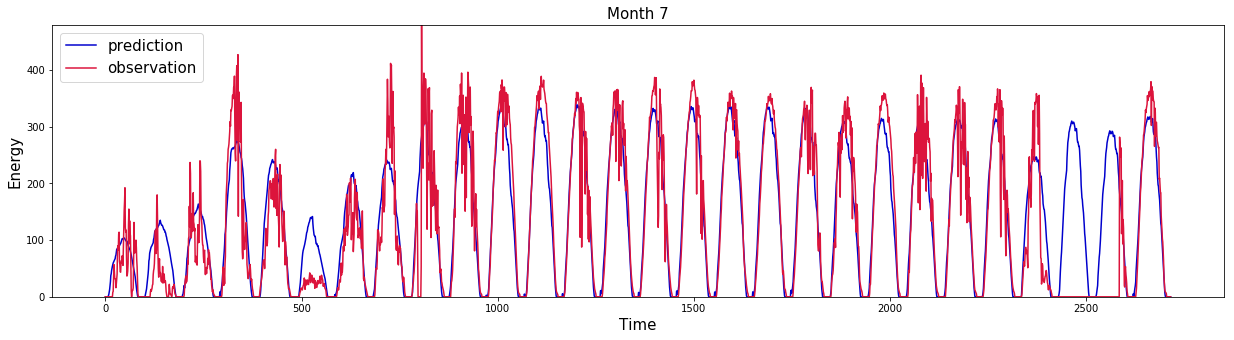

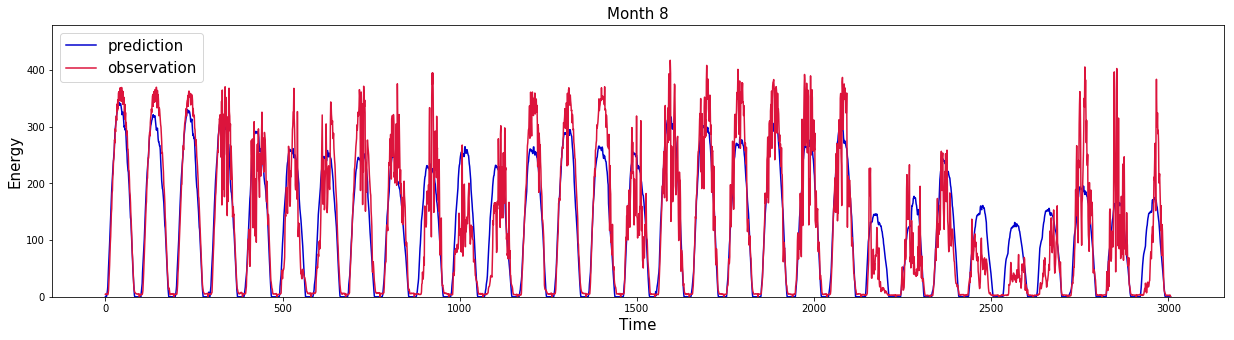

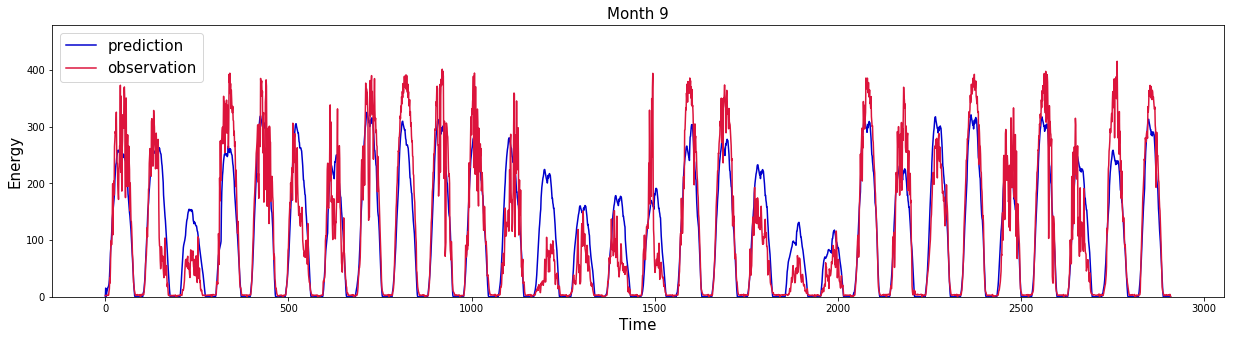

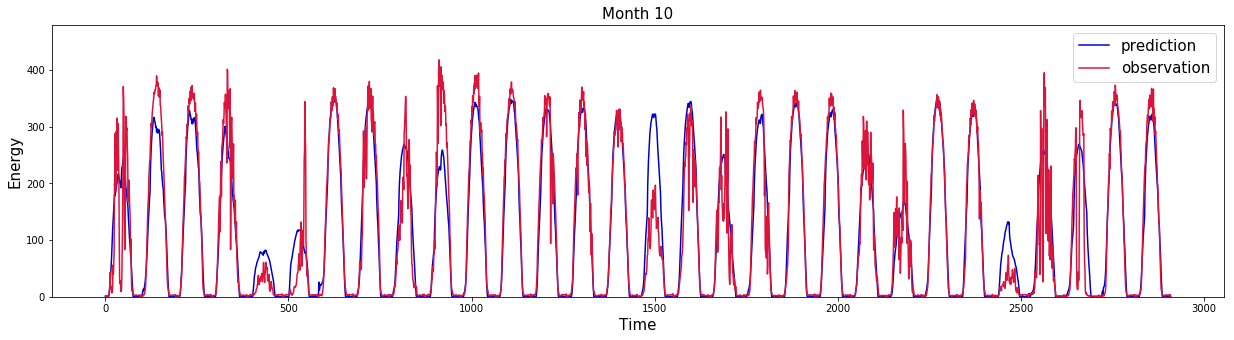

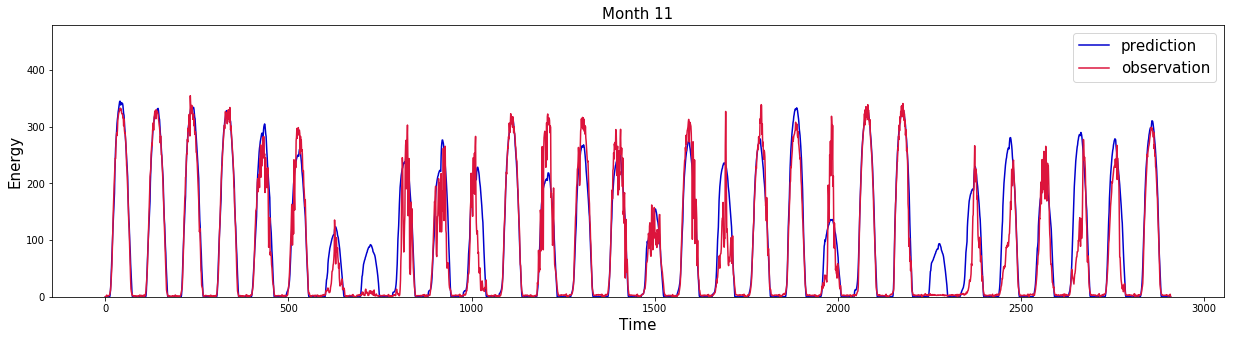

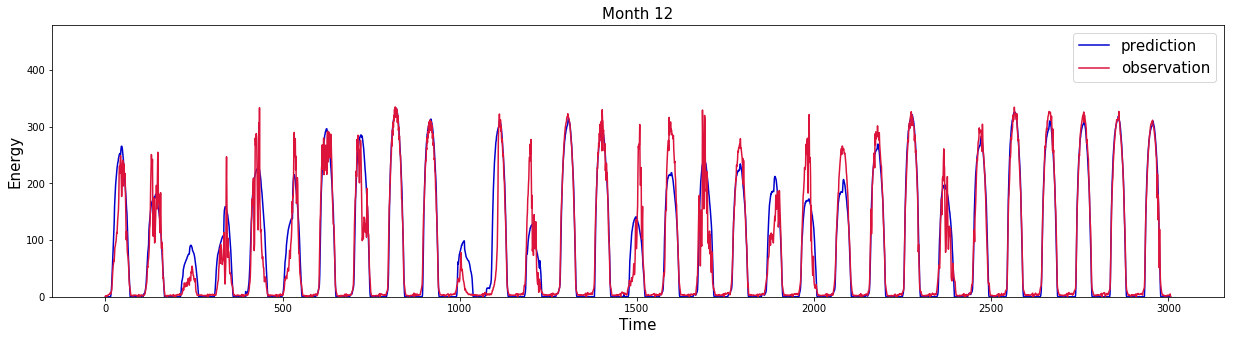

In [16]:
# epoch = 50
month_index = month_index.astype('int')
for i in range(12):
    plt.figure(figsize = (21,5))
    plt.plot(predicted[month_index[i]*interval: month_index[i+1]*interval].cpu().numpy()*solar_max, label = 'prediction', color = 'mediumblue')
    plt.plot(whole_data[month_index[i]*interval: month_index[i+1]*interval].cpu().numpy()*solar_max, label = 'observation', color = 'crimson')
    plt.title('Month %d' %(i+1), fontsize = 15)
    plt.ylabel('Energy', fontsize = 15)
    plt.xlabel('Time', fontsize = 15)
    plt.ylim([0,solar_max])
    plt.legend(fontsize=15)

In [17]:
# epoch = 50
month_index = month_index.astype('int')
for i in range(12):
    test_loss = loss(predicted[month_index[i]*interval: month_index[i+1]*interval], whole_data[month_index[i]*interval: month_index[i+1]*interval])
    NRMSE = torch.sqrt(test_loss) / whole_data[month_index[i]*interval: month_index[i+1]*interval].max()
    NMAE = torch.sum(torch.abs(predicted[month_index[i]*interval: month_index[i+1]*interval]-whole_data[month_index[i]*interval: month_index[i+1]*interval])) * 100 * solar_max / len(predicted[month_index[i]*interval: month_index[i+1]*interval]) / capacity_value
    print("Month %d NRMSE: %f" %(i+1, NRMSE))
    print("Month %d NMAE: %f" %(i+1, NMAE))

Month 1 NRMSE: 0.162456
Month 1 NMAE: 6.253412
Month 2 NRMSE: 0.104432
Month 2 NMAE: 5.225589
Month 3 NRMSE: 0.132642
Month 3 NMAE: 6.565126
Month 4 NRMSE: 0.085928
Month 4 NMAE: 4.893518
Month 5 NRMSE: 0.119304
Month 5 NMAE: 7.338408
Month 6 NRMSE: 0.136450
Month 6 NMAE: 7.884869
Month 7 NRMSE: 0.140584
Month 7 NMAE: 8.040405
Month 8 NRMSE: 0.129236
Month 8 NMAE: 7.537122
Month 9 NRMSE: 0.131938
Month 9 NMAE: 7.456787
Month 10 NRMSE: 0.107626
Month 10 NMAE: 5.176836
Month 11 NRMSE: 0.119598
Month 11 NMAE: 4.584902
Month 12 NRMSE: 0.101714
Month 12 NMAE: 3.642590


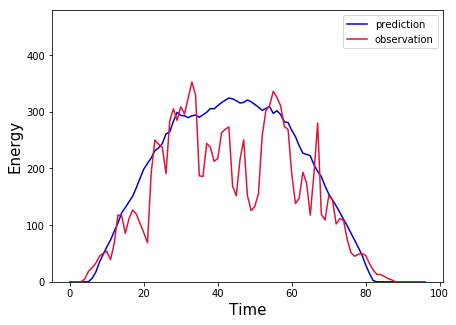

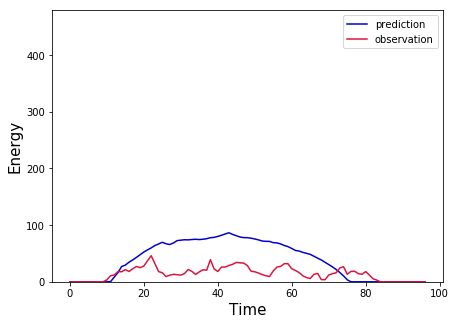

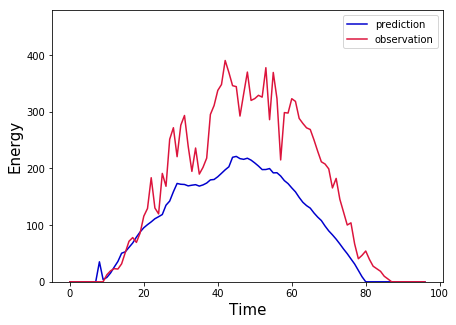

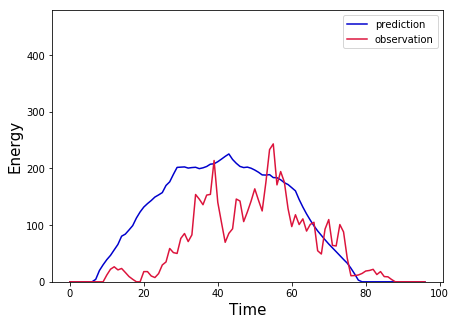

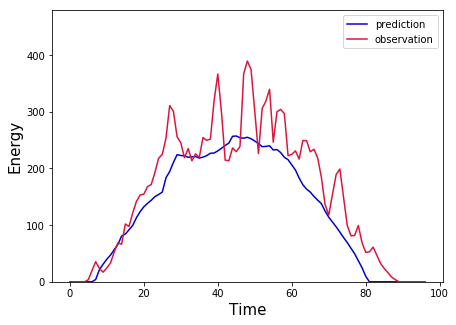

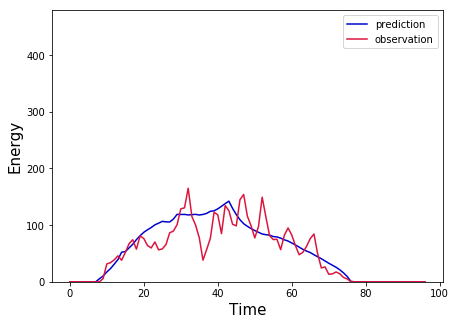

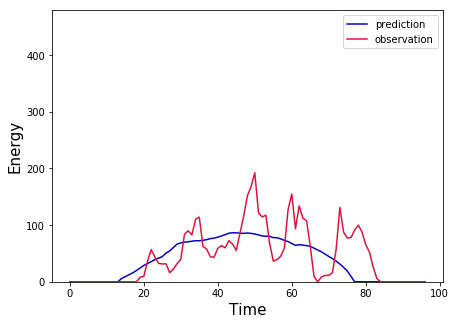

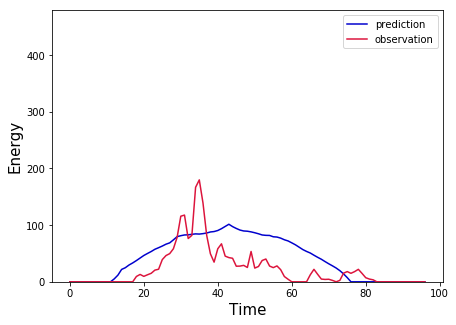

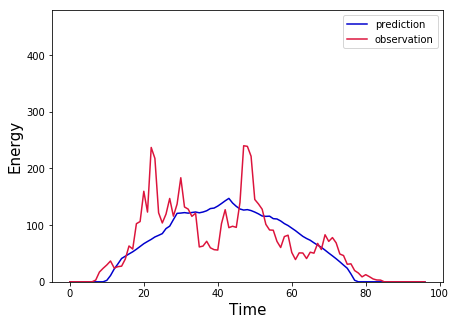

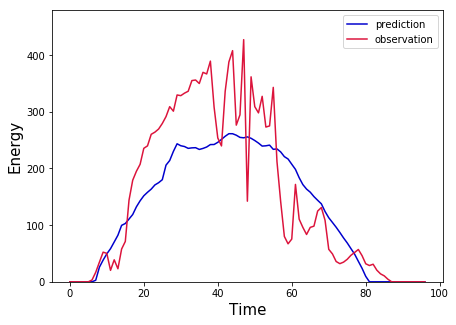

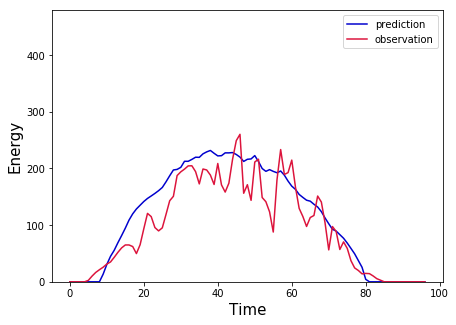

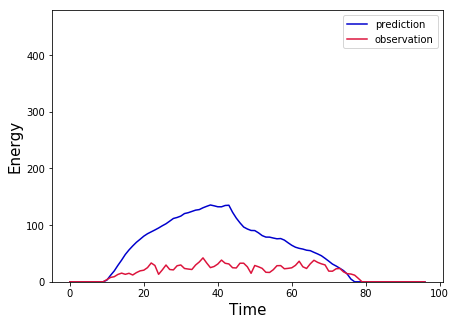

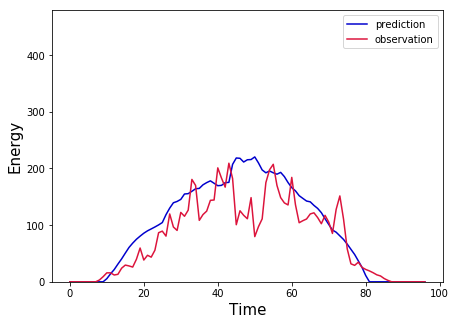

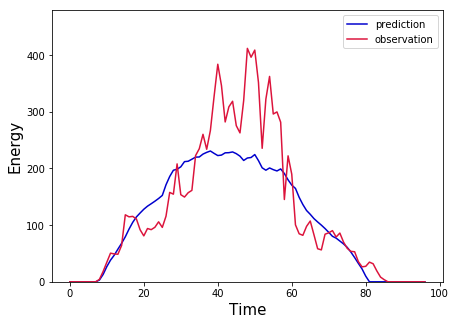

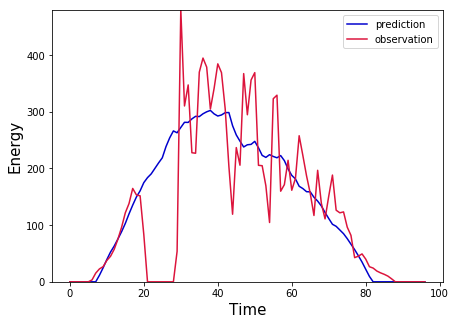

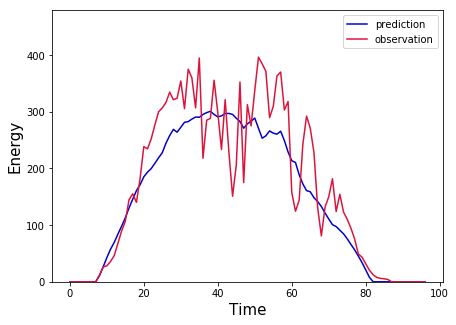

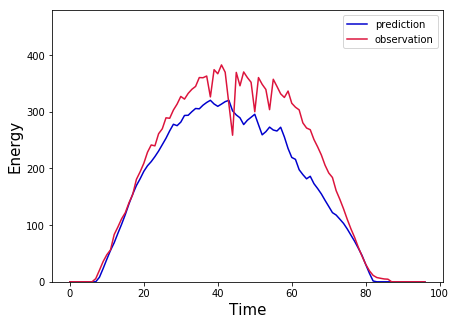

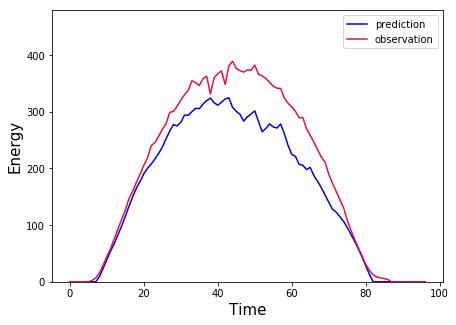

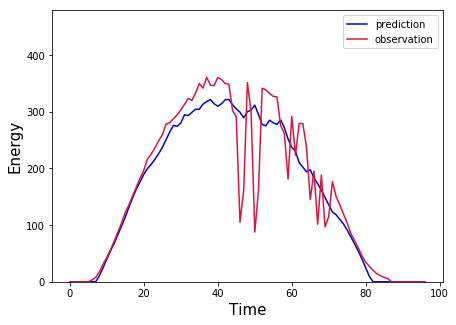

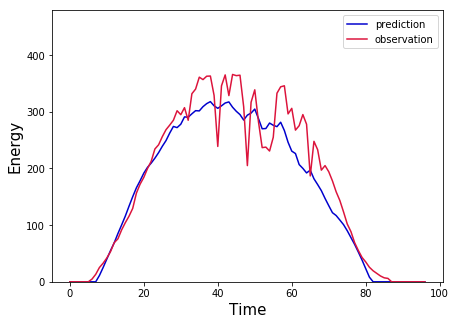

In [19]:
index = 150
for i in range(20):
    dec = evaluate(encoder1, decoder1, s2_input_series[interval*index + interval*i], s2_target_series[interval*index + interval*i], interval)
    plt.figure(figsize = (7,5))
    plt.plot(np.array(dec) * solar_max, label = 'prediction', color = 'mediumblue')
    plt.ylabel('Energy', fontsize = 15)
    plt.xlabel('Time', fontsize = 15)
    plt.plot(s2_target_series[interval*index + interval*i, :, 0].cpu().numpy() * solar_max, label = 'observation', color = 'crimson')
    plt.ylim([0,solar_max])
    plt.legend()
    plt.show()

# Total generation

In [18]:
predicted_sum = torch.zeros(int(len(predicted)/interval))
target_sum = torch.zeros(int(len(predicted)/interval))
                         
for i in range(int(len(predicted)/interval)):
    predicted_sum[i] = torch.sum(predicted[i*interval: (i+1)*interval])
    target_sum[i] = torch.sum(whole_data[i*interval: (i+1)*interval])                             

In [19]:
total_mse = loss(predicted_sum, target_sum)
total_nrmse = torch.sqrt(total_mse) / torch.max(target_sum)
total_nmae = torch.sum(torch.abs(predicted_sum - target_sum)) / len(predicted_sum) / torch.max(target_sum) * 100
print("Total generation NRMSE: %f" %(total_nrmse))
print("Total generation NMAE: %f" %(total_nmae))

Total generation NRMSE: 0.137729
Total generation NMAE: 9.768746


In [20]:
for i in range(12):
    test_loss = loss(predicted_sum[month_index[i]: month_index[i+1]], target_sum[month_index[i]: month_index[i+1]])
    NRMSE = torch.sqrt(test_loss) / torch.max(target_sum)
    NMAE = torch.sum(torch.abs(predicted_sum[month_index[i]: month_index[i+1]]-target_sum[month_index[i]: month_index[i+1]])) / len(predicted_sum[month_index[i]: month_index[i+1]]) / torch.max(target_sum) * 100
    print("Month %d GEN NRMSE: %f" %(i+1, NRMSE))
    print("Month %d GEN NMAE: %f" %(i+1, NMAE))    

Month 1 GEN NRMSE: 0.175898
Month 1 GEN NMAE: 12.691578
Month 2 GEN NRMSE: 0.119187
Month 2 GEN NMAE: 7.599839
Month 3 GEN NRMSE: 0.173543
Month 3 GEN NMAE: 12.668053
Month 4 GEN NRMSE: 0.076094
Month 4 GEN NMAE: 5.908058
Month 5 GEN NRMSE: 0.151792
Month 5 GEN NMAE: 11.690437
Month 6 GEN NRMSE: 0.170810
Month 6 GEN NMAE: 13.363025
Month 7 GEN NRMSE: 0.199835
Month 7 GEN NMAE: 11.304877
Month 8 GEN NRMSE: 0.117447
Month 8 GEN NMAE: 9.841249
Month 9 GEN NRMSE: 0.140869
Month 9 GEN NMAE: 12.340792
Month 10 GEN NRMSE: 0.097799
Month 10 GEN NMAE: 7.239390
Month 11 GEN NRMSE: 0.103578
Month 11 GEN NMAE: 7.996751
Month 12 GEN NRMSE: 0.063904
Month 12 GEN NMAE: 4.801539


In [21]:
df3 = pd.DataFrame({'DATE': df2.iloc[interval:interval + interval* test_day, 4]})
df3['GEN_ENERGY'] = whole_data.cpu().numpy()*solar_max
df3['PREDICTED_E'] = predicted.cpu().numpy()*solar_max
df3['TOTAL_ENERGY'] = np.repeat(target_sum, 97) * solar_max
df3['TOTAL_PREDICTED'] = np.repeat(predicted_sum, 97) * solar_max

In [22]:
df3.to_csv('Result_24h.csv')